In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as scs
import scipy
from sklearn.linear_model import LogisticRegression, LinearRegression
import itertools
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [51]:
def generate_classes(nptses, mus, sds):
    """
    Generate normally distributed points in multiple classes
    Parameters
    ----------
    nptses : array_like (1-d)
        sequence of numbers, the count of points in each class
    mus : array_like (2-d)
        sequence of vectors, the means of the multivariate distributions for each class
    mus : array_like (3-d)
        sequence of 2-d symmetric tensors, the standard deviation of the multivariate
        distributions for each class
        
    Returns
    -------
    X : array (2-d)
        features of generated points
    y : array (2-d)
        integer labels of points, starting at 0
    """

    X = np.zeros((0,2))
    y = np.zeros((0,))
    
    for i, npts, mu, sd in zip(itertools.count(), nptses, mus, sds):
        X = np.concatenate([X, scs.multivariate_normal(mu, sd).rvs(npts)])
        y = np.concatenate([y, np.ones(npts)*i])
    return X, y

In [52]:
def decision_boundary_x2(x, b0, b1, b2, threshold):
    return (np.log((1 - threshold)/threshold) - b0 - x*b1 )/b2

def plot_decision_boundary(X, y, model, ax=None):
    '''plot 2-d array of points, with decision boundaries'''
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(X[:,0], X[:,1], color=np.where(y, 'g', 'b'), alpha=0.5, s=3)
    ax.plot(*X[y==0].mean(axis=0).reshape(-1,1), color='b', marker='+', mew=4, ms=20)
    ax.plot(*X[y==1].mean(axis=0).reshape(-1,1), color='g', marker='+', mew=4, ms=20)
    ax.axis('equal')

    xmin, xmax = X[:,0].min(), X[:,0].max()
    xrng = np.array([2*xmin-xmax, 2*xmax-xmin])

    ylim = ax.get_ylim()
    xlim = ax.get_xlim()

    beta0 = model.intercept_
    beta1, beta2 = model.coef_[0]
    print (beta0, beta1, beta2)
    
    for threshold, ls in zip(1/(1+np.exp(-np.arange(-3,4))), [':', '-.', '--', '-', '--', '-.', ':']):
        ax.plot(xrng,
                decision_boundary_x2(xrng, beta0, beta1, beta2, threshold),
                color='r',
                ls=ls,
                label="{:.2f}%".format(threshold*100))
    ax.legend(title='threshold')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


In [53]:
X, y = generate_classes((1000,1000),
                       ((2.0, 2.5),
                        (6.0, 0.0)),
                       (((2.0, 0),
                         (0, 3.0)),
                        ((2.5, 0),
                         (0, 3.0)))
                       )
model = LogisticRegression(C=1000)
model.fit(X, y)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [54]:
X,y

(array([[ 0.48494858,  3.07967423],
        [ 0.83485565,  0.66742711],
        [ 4.5440166 ,  1.30408577],
        ...,
        [ 6.70268017,  1.54423642],
        [ 6.47279627, -3.8567261 ],
        [ 6.75336331,  0.6928242 ]]), array([0., 0., 0., ..., 1., 1., 1.]))

In [55]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df
# df['fpr']    

def plot_roc(ax, df):
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label="ROC")
    ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.set_title('ROC Curve')
    ax.legend()
    
def plot_precision_recall(ax, df):
    ax.plot(df.tpr,df.precision, label='precision/recall')
    #ax.plot([0,1],[0,1], 'k')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision/Recall Curve')
    ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
    ax.set_xlim(xmin=0,xmax=1)
    ax.set_ylim(ymin=0,ymax=1)

In [56]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    
#     print ("TPR: ", df['tpr'])
#     print ("FPR ", df['fpr'])
#     print ("Threshold: ", + ['prob'])
    df_roc = df[['tpr','fpr','prob']]

    return df_roc
# TPRs, FPRs, thresholds
# df['tpr']
# df['fpr']
# df['prob']
calculate_threshold_values(model.predict_proba(X)[:,1], y)


,tpr,fpr,prob
0,1.000,0.999,0.000001
1,1.000,0.998,0.000001
2,1.000,0.997,0.000004
3,1.000,0.996,0.000006
4,1.000,0.995,0.000006
5,1.000,0.994,0.000013
6,1.000,0.993,0.000013
7,1.000,0.992,0.000013
8,1.000,0.991,0.000014
9,1.000,0.990,0.000015


AttributeError: 'DataFrame' object has no attribute 'precision'

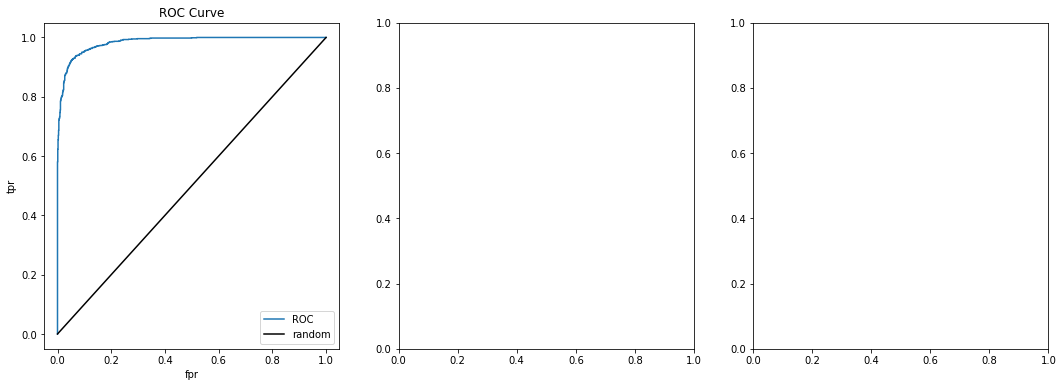

In [57]:

fig, (ax0, ax1, ax3) = plt.subplots(1,3, figsize=(18,6))
df = calculate_threshold_values(model.predict_proba(X)[:,1], y)
plot_roc(ax0, df)
plot_precision_recall(ax1, df)
plot_decision_boundary(X, y, model, ax3)

In [ ]:
len(y)
labels = y
prob = probabilities
len(probabilities)

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# def calculate_threshold_values(prob, y):
# df = calculate_threshold_values(model.predict_proba(X)[:,1], y)

def ROC_curve(probabilities, labels):
    '''
    Sort instances by their prediction strength (the probabilities)
    For every instance in increasing order of probability:
        Set the threshold to be the probability
        Set everything above the threshold to the positive class
        Calculate the True Positive Rate (aka sensitivity or recall)
        Calculate the False Positive Rate (1 - specificity)
    Return three lists: TPRs, FPRs, thresholds
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    
    
    
    return df

# ROC_curve(calculate_threshold_values(model.predict_proba(X)[:,1], labels))
# def plot_roc(ax, df):
#     ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label="ROC")
#     ax.plot([0,1],[0,1], 'k', label="random")
#     ax.set_xlabel('fpr')
#     ax.set_ylabel('tpr')
#     ax.set_title('ROC Curve')
#     ax.legend()
    

    
#     ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label="ROC")
#     ax.plot([0,1],[0,1], 'k', label="random")
#     ax.set_xlabel('fpr')
#     ax.set_ylabel('tpr')
#     ax.set_title('ROC Curve')
#     ax.legend()

In [ ]:
model.predict_proba(X)[:,1]

In [ ]:
#     ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label="ROC")
#     ax.plot([0,1],[0,1], 'k', label="random")
#     ax.set_xlabel('fpr')
#     ax.set_ylabel('tpr')
#     ax.set_title('ROC Curve')
#     ax.legend()

# calculate_threshold_values(model.predict_proba(X)[:,1], y) <--- DF

In [ ]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    
#     print ("TPR: ", df['tpr'])
#     print ("FPR ", df['fpr'])
#     print ("Threshold: ", + ['prob'])
    df_roc = df[['tpr','fpr','prob']]

    return df_roc


# TPRs, FPRs, thresholds
# df['tpr']
# df['fpr']
# df['prob']
# calculate_threshold_values(probabilities, y_test)

# tpr = calculate_threshold_values(probabilities, y_test)['tpr']
# fpr = calculate_threshold_values(probabilities, y_test)['fpr']
# prob = calculate_threshold_values(probabilities, y_test)['prob']

# thresholds = calculate_threshold_values(probabilities, y_test)['prob']



In [ ]:

# print(tpr, fpr, thresholds)
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                        n_clusters_per_class=2, n_samples=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LogisticRegression()
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]

tpr, fpr, thresholds = calculate_threshold_values(probabilities, y_test)

# print(calculate_threshold_values(probabilities, y_test))

# calculate_threshold_values(probabilities, y_test)['tpr']

tpr = calculate_threshold_values(probabilities, y_test)['tpr']
fpr = calculate_threshold_values(probabilities, y_test)['fpr']










# print(tpr,fpr thresholds)


plt.plot(fpr, tpr)
# plt.plot(.1, .9)

plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of fake data")
plt.show()


In [58]:
tpr, fpr, thresholds = calculate_threshold_values(probabilities, y_test)

In [59]:
import pandas as pd
df = pd.read_csv('data/loanf.csv')
y = (df['Interest.Rate'] <= 12).values
X = df[['FICO.Score', 'Loan.Length', 'Loan.Amount']].values


In [60]:
y

array([False, False, False, ...,  True,  True, False])

In [61]:
X

array([[  670,    36,  6000],
       [  670,    36,  2000],
       [  665,    36, 10625],
       ...,
       [  810,    36, 27000],
       [  765,    36, 25000],
       [  740,    60, 16000]])

In [68]:
import src.roc_curve as rc

In [69]:
roc_soln = rc.roc_curve(probabilities, y_test)

In [70]:
roc_soln